In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/MyDrive/ColabNotebooks/HDA'

/content/drive/MyDrive/ColabNotebooks/HDA


In [ ]:
!pip install tensorflow-io
!pip install psutil
!pip install tensorflow
!pip install keras-tuner
!pip install einops

In [4]:
import threading
import psutil
import random
import time
import subprocess
import sys
import seaborn as sns
import pandas as pd
import os
import numpy as np
from config import PREPROCESSING_PATH ,DATASET_SPLIT_PATH
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io import wavfile
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_tuner import BayesianOptimization, HyperModel
from einops.layers.tensorflow import Rearrange
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,accuracy_score

In [5]:
import preprocessing_tf
import evaluation

In [6]:
random.seed(42)
tf.random.set_seed(42)

In [7]:
print("Number of GPU:", len(tf.config.list_physical_devices('GPU')))
print("Version:", tf.__version__)

Number of GPU: 1
Version: 2.15.0


# Dataset Loading

To improve training efficiency, the dataset is pre-loaded into runtime, avoiding slow read speeds from the drive. It's already divided into train, validation, and test folders.

In [8]:
%cd /content/drive/MyDrive/ColabNotebooks/HDA

/content/drive/MyDrive/ColabNotebooks/HDA


In [9]:
!unzip project_data_split.zip -d /content/data

In [10]:
DATASET_SPLIT_PATH = "/content/data/project_data_split"

# Create train and validation dataset

Construct dataframes that includes the file paths and the corresponding spoken command (label) for each audio sample. The dataset comprises audio samples of 25 keywords: `backward`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `learn`, `left`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `six`, `stop`, `three`, `two`, `up`, `visual`, `yes`, `zero`. Additionally, it contains 10 words `bed`,`bird`,`cat`, `dog`,`happy`,`house`,`marvin`,`sheila`,`tree`,`wow` that the model should not recognize as keywords.

To facilitate model training and evaluation, the labels are appropriately mapped: labels corresponding to the 25 keywords are retained in their original form, signifying that these are the commands the model is expected to recognize. Conversely, the labels for the 10 non-keyword words are mapped to a single class named "unknown". This approach consolidates these distinct non-keyword labels into a single category, simplifying the model's task by reducing the classification scope to the keywords and an "unknown" class for any non-keyword utterances.

In [11]:
train_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"train"))
val_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"validation"))

In [12]:
train_df.head()

,filepath,label,mapped_label
0,/content/data/project_data_split/train/eight/8...,eight,eight
1,/content/data/project_data_split/train/eight/2...,eight,eight
2,/content/data/project_data_split/train/eight/2...,eight,eight
3,/content/data/project_data_split/train/eight/3...,eight,eight
4,/content/data/project_data_split/train/eight/b...,eight,eight


In [13]:
file_paths = tf.constant(train_df['filepath'].values)
labels = tf.constant(train_df['mapped_label'].values)

In [14]:
# Create a StringLookup layer
#label_lookup = label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(labels)
# Transform labels into numeric
numeric_labels = label_lookup(labels)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((file_paths, numeric_labels))

In [15]:
file_paths_val = tf.constant(val_df['filepath'].values)
labels_val = tf.constant(val_df['mapped_label'].values)
numeric_labels_val = label_lookup(labels_val)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_paths_val, numeric_labels_val))

# Preprocessing the Datasets

The training and validation datasets undergo preprocessing through our established pipeline. For the baseline model, the preprocessing involves only two steps: padding the data to ensure uniformity in size, which is essential for the model's input requirements, and converting the audio files into spectrograms.

In [16]:
train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,noise=True, mfcc=True),
                               num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

val_spectrogram_ds = validation_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,noise=True, mfcc=True),
                               num_parallel_calls=tf.data.AUTOTUNE)

val_spectrogram_ds= val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Padding shape: (16000,)
/content/data/project_data_split/_background_noise_/doing_the_dishes.wav
Noisy shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)
Padding shape: (16000,)
/content/data/project_data_split/_background_noise_/white_noise.wav
Noisy shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)


In [17]:
batch_size = 32
train_spectrogram_ds = train_spectrogram_ds.batch(batch_size)
val_spectrogram_ds = val_spectrogram_ds.batch(batch_size)

In [18]:
input_shape =train_spectrogram_ds.element_spec[0].shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_lookup.get_vocabulary())
print('Number of labels:', num_labels)

Input shape: (98, 40, 1)
Number of labels: 26


# CNN

In [19]:
class CNN_TPool3_HyperModel(HyperModel):
    def __init__(self, input_shape, num_labels):
        self.input_shape = input_shape
        self.num_labels = num_labels

    def build(self, hp):
        inputs = tf.keras.Input(shape=self.input_shape)

        m = hp.Int('m', min_value=10, max_value=20, step=1)  # Time filter size
        r = hp.Int('r', min_value=4, max_value=6, step=1)   # Frequency filter size
        n = hp.Int('n', min_value=64, max_value=128, step=16) # Number of feature maps
        p = hp.Int('p', min_value=1, max_value=2, step=1)   # Pooling in time
        q = hp.Int('q', min_value=1, max_value=2, step=1)   # Pooling in frequency

        # Convolutional Layer
        x = layers.Conv2D(filters=n, kernel_size=(m, r), strides=(1, 1), activation='relu', padding='valid')(inputs)

        # Max Pooling in time
        x = layers.MaxPooling2D(pool_size=(p, 1), strides=(p, 1), padding='valid')(x)

        # Second Convolutional Layer
        x = layers.Conv2D(filters=n, kernel_size=(6, r), strides=(1, 1), activation='relu', padding='valid')(x)

        # Max Pooling in frequency
        x = layers.MaxPooling2D(pool_size=(1, q), strides=(1, q), padding='valid')(x)

        # Flatten the output for Dense layers
        x = layers.Flatten()(x)

        # Dense layers
        x = layers.Dense(32, activation='relu')(x)

        # Output layer
        outputs = layers.Dense(self.num_labels, activation='softmax')(x)

        # Create and compile model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                      loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'])
        return model


In [22]:
# Create hypermodel and tuner
hypermodel = CNN_TPool3_HyperModel(input_shape=input_shape, num_labels=num_labels)


In [23]:
tuner = BayesianOptimization(
    hypermodel,
    objective='val_sparse_categorical_accuracy',
    max_trials=50,
    max_consecutive_failed_trials=50,
    max_model_size=2 * 10 ** 6,
    directory='cnn_tpool3_tuning',
    project_name='cnn_tpool3_hyperopt',
    overwrite=False
)

In [24]:
model_name = 'CNN_Test'
num_epochs = 20
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
patience=5)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)


In [25]:
# Perform hyperparameter search
tuner.search(train_spectrogram_ds,
             validation_data=val_spectrogram_ds,
             epochs=num_epochs,
             callbacks=[early_stop_callback, reduce_LR, model_checkpoint],
             verbose=1)

Trial 50 Complete [00h 00m 00s]

Best val_sparse_categorical_accuracy So Far: 0.3579801619052887
Total elapsed time: 00h 45m 13s


In [26]:
# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

best_model.summary()

{'m': 15, 'r': 6, 'n': 80, 'p': 2, 'q': 2}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 98, 40, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 84, 35, 80)        7280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 35, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 30, 80)        230480    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 15, 80)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)

In [ ]:
best_model.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='sparse_categorical_crossentropy',
                   metrics=['sparse_categorical_accuracy'])


In [30]:
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_cnn_model_train.txt'
interval = 30

In [31]:
epochs = 100
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

In [32]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [33]:
start_time = time.time()

history = best_model.fit(train_spectrogram_ds,
                         validation_data=val_spectrogram_ds,
                         epochs=epochs,
                         callbacks=[early_stop_callback, reduce_LR],
                         verbose=1)

end_time = time.time()
cpu_usage_train = evaluation.get_system_ram_usage()
stop_event.set()
thread.join()
total_time_train = end_time - start_time
print(f"CPU Usage: {cpu_usage_train} GB")
print(f"Total training time: {total_time_train} seconds")

Epoch 1/100
2652/2652 [==============================] - 44s 16ms/step - loss: 0.1007 - sparse_categorical_accuracy: 0.9702 - val_loss: 3.0836 - val_sparse_categorical_accuracy: 0.3498 - lr: 1.0000e-04
Epoch 2/100
2652/2652 [==============================] - 42s 16ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9746 - val_loss: 3.3313 - val_sparse_categorical_accuracy: 0.3430 - lr: 1.0000e-04
Epoch 3/100
2652/2652 [==============================] - 43s 16ms/step - loss: 0.0792 - sparse_categorical_accuracy: 0.9773 - val_loss: 3.2247 - val_sparse_categorical_accuracy: 0.3429 - lr: 1.0000e-04
Epoch 4/100
2650/2652 [============================>.] - ETA: 0s - loss: 0.0733 - sparse_categorical_accuracy: 0.9790
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2652/2652 [==============================] - 43s 16ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9790 - val_loss: 3.1752 - val_sparse_categorical_accuracy: 0.3489 - lr: 1.0000e-04
Epoch 5/10

In [34]:
best_model.save('Models/cnn_tpool3_retrained', save_format='tf')

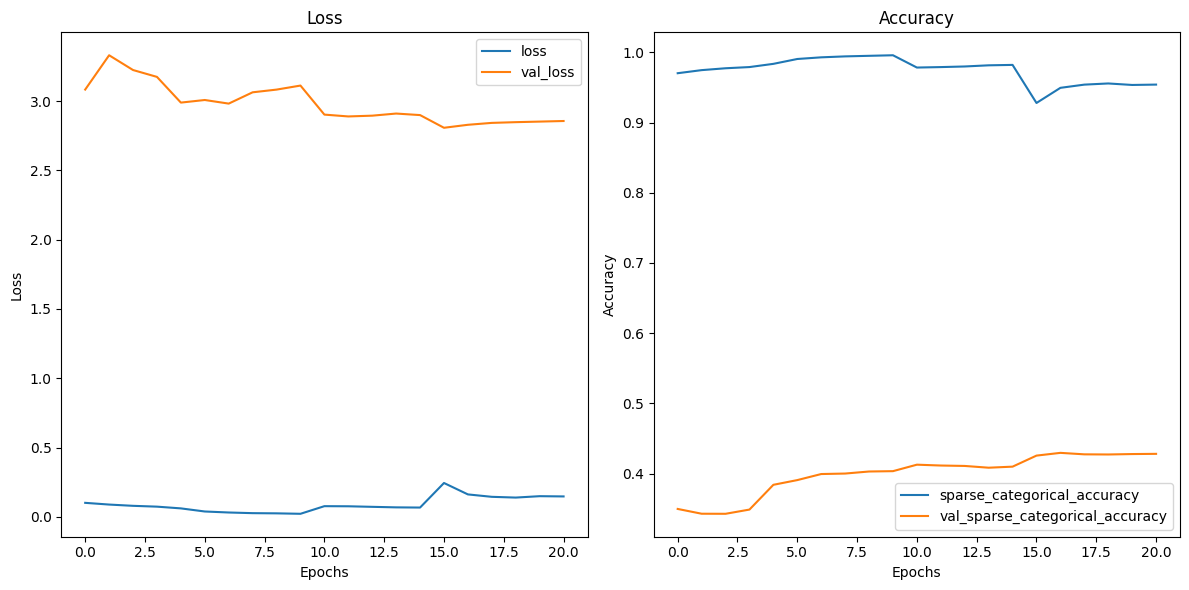

In [35]:
evaluation.plot_fit_history(history, ['loss', 'val_loss'],['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

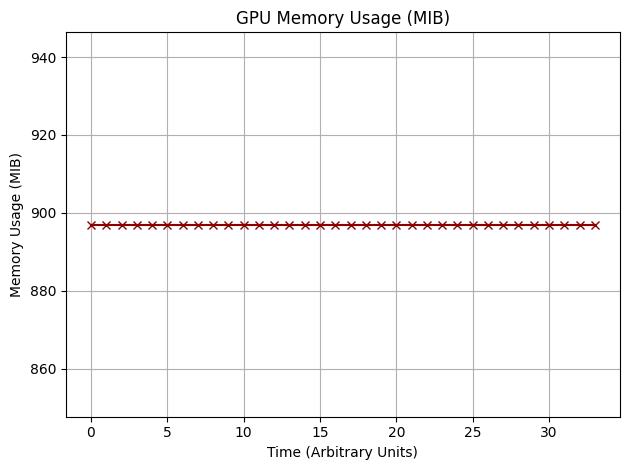

In [36]:
#get and plot memory usage
df_gpu_train = evaluation.get_gpu_usage(log_file_path)

# Evaluation

In [52]:
test_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"test"))
file_paths_test = tf.constant(test_df['filepath'].values)
labels_test = tf.constant(test_df['mapped_label'].values)
numeric_labels_test = label_lookup(labels_test)
test_dataset = tf.data.Dataset.from_tensor_slices((file_paths_test, numeric_labels_test))

In [53]:
test_spectrogram_ds = test_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl, mfcc=True, noise=False),
                               num_parallel_calls=tf.data.AUTOTUNE)

Padding shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)


In [54]:
batch_size = 32
test_spectrogram_ds = test_spectrogram_ds.batch(batch_size)

In [55]:
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_cnn_model_test.txt'
interval = 10

In [56]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [57]:
start_time = time.time()
predictions = best_model.predict(test_spectrogram_ds)
end_time = time.time()
cpu_usage_test= psutil.cpu_percent() * 12.7
stop_event.set()
total_time_test = end_time - start_time
print(f"Total testing time: {total_time_test} seconds")

344/344 [==============================] - 14s 39ms/step
Total testing time: 20.682443618774414 seconds


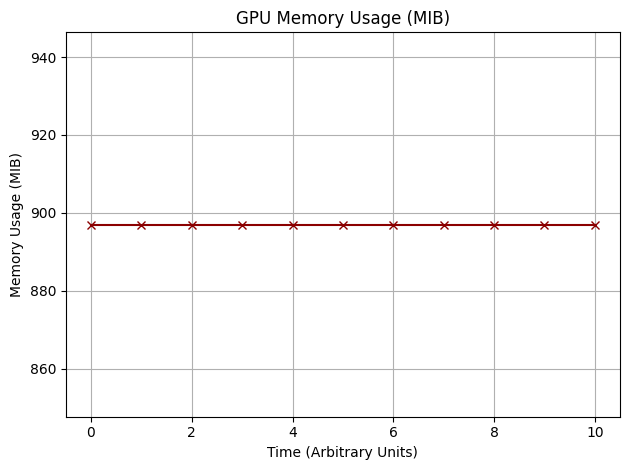

In [58]:
#get and plot the train memory usage
df_gpu_test = evaluation.get_gpu_usage(log_file_path)

In [59]:
true_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)
metrics_df = evaluation.get_error_metrics("CNN Model", true_labels, predictions)
metrics_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,CNN Model,0.054713,0.048617,0.012815,0.045706,3.257538


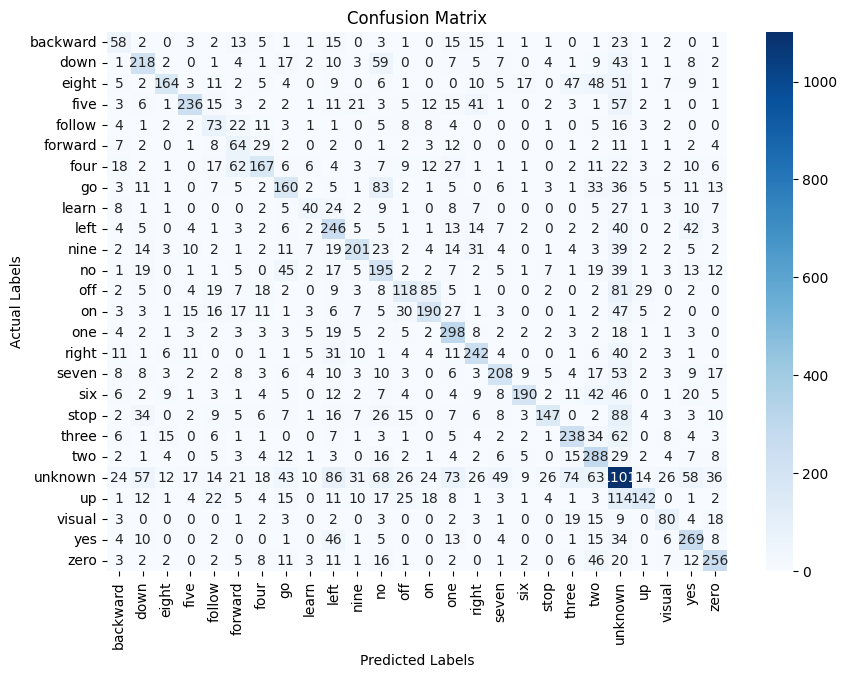

In [45]:
evaluation.plot_confusion_matrix(true_labels,predictions,label_lookup)

# Summary

In [47]:
mean_train = df_gpu_train['Memory Usage (MiB)'].mean()
mean_test = df_gpu_test['Memory Usage (MiB)'].mean()
max_train = df_gpu_train['Memory Usage (MiB)'].max()
max_test = df_gpu_test['Memory Usage (MiB)'].max()
total_params = best_model.count_params()

In [48]:
print(f"Training time: {total_time_train:.3f} seconds")
print(f"Average GPU usage train: {mean_train:.3f} MiB")
print(f"Maximum GPU usage train: {max_train:.3f} MiB")
print(f"CPU usage train: {cpu_usage_train:.3f} GB")

print(f"Testing time: {total_time_test:.3f} seconds")
print(f"Average GPU usage test: {mean_test:.3f} MiB")
print(f"Maximum GPU usage test: {max_test:.3f} MiB")
print(f"CPU usage test: {cpu_usage_test:.3f} GB")

print(f"Number of parameters: {total_params}")

metrics_df.head()

Training time: 1014.637 seconds
Average GPU usage train: 897.000 MiB
Maximum GPU usage train: 897.000 MiB
CPU usage train: 3.847 GB
Testing time: 56.461 seconds
Average GPU usage test: 897.000 MiB
Maximum GPU usage test: 897.000 MiB
CPU usage test: 563.880 GB
Number of parameters: 1659450


,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Conformer Model,0.515534,0.487152,0.486483,0.50786,2.831329


#References


Tara N. Sainath and Carolina Parada, "Convolutional neural networks for small-footprint keyword spotting"